<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Linear_systems_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GOALS:
- Grasp the basic concept of Jacobi, Gauss-Seidel, and Successive Over Relaxation iterative methods
- Understand the pros and cons of each method
- Experience the benefit of iterative solvers

#Iterative systems

Guass Elimination / LU decomposition are *direct* solvers in that they solve systems in a fixed number of operations. If we could calculate in infinite precision these answers would be exact. Direct solvers generally scale ~$O(n^3)$ and are therefore impractical for large systems.

We will now talk about *iterative / indirect methods* which start with an initial guess and iterate (hopefully) towards a solution. Each iteration is typically faster and more memory efficient than direct solvers, but convergence is only guaranteed under certain limited circumstances. Even then, the *rate of convergence* can still make these techniques impractical.





Iterative techniques have some useful properties:
1. They are self-correcting in that roundoff (or arithmatic) errors are corrected through further cycles.
2. They are more conducive to sparse matrix storage.

Only the solution vector $x$ is altered during these computations. Neither the matrix (nor anything we will do to it) is not altered during any of these steps!

> In fact, there are a class of solvers called *matrix free* solvers that avoid the explicit writing of $A$ entirely... This is useful if the matrix product $Ax$ can be calculated in a more effective manner such that we don't bother writing out and storing A$!

Each iteration will (hopefully) improve the answer asymptotically, so we estimate the error and say when it is stopped getting better. As discussed with error analysis, this involves defining tolerances for computation.

##Iterative approach

Consider: What does it mean for a vector $x$ to satisfy $Ax=b$?

-> All the elements in $x$ must be *consistent*.

What if one element was not consistent?

-> We could solve for it based on the others!

##Big picture algorithm
1. Start with a guess
2. For each iterative step, identify a single element in $x$, make it consistent with all the others.
3. Check how well the guess solves the linear system
4. Repeat (possibly updating a parameter first)

### Quantifying convergence

The system has converged when $Ax=b$. Define the *residual vector*, $R = Ax-b$ such that when $R\rightarrow 0$ (the system is converged).

Let's use the norm (some measure of magnitude) of $R$  and say the system has converged when $||R|| \lt tolerance$.

> Should we use absolute tolerance or relative?

> What other tolerance could we imagine using? (Hint: We are actually interested $x$...)

#Jacobi iteration method

Begin by writing out the linear system in index form:

$$
\begin{align*}
A x &= b \\
\sum_{j} A_{ij} x_j&=b_i \\
\begin{bmatrix}
a_{1,1} & a_{1,2} & ... & a_{1,n}\\
a_{2,1} & a_{2,2} & ... & a_{2,n}\\
... & ... & ... & ... \\
a_{m,1} & a_{m,2} & ... & a_{m,n}
\end{bmatrix}\left[\begin{array}{c} x_1 \\x_2 \\ ... \\x_n \end{array}\right] &=
\left[\begin{array}{c} b_1 \\b_2 \\ ... \\b_m \end{array}\right]
\end{align*}$$

Extract the $i$th row, and solve for the diagonal term:

$$\begin{aligned}
A_{ii}x_i^{k+1} &+ \sum_{j \ne i} A_{ij} x_j^k  = b_i \\
x_i^{k+1} &= \frac{1}{A_{ii}}\left[b_i-\sum_{j \ne i} A_{ij} x_j^k\right]
\end{aligned}$$

This makes $x_i^{k+1}$ consistent with all the other elements.

We can write this in matrix form by pulling appart $A$ along its diagonal, $D$, into the upper $U$ and lower $L$ matricies:

$A = L + D + U$

NB: This is not a matrix decomposition; we are literally just pulling it apart (blank elements are zeros):

$$\begin{bmatrix} a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33} \end{bmatrix} = \begin{bmatrix}  &  &  \\ a_{21} &  &  \\ a_{22} & a_{23} & 0 \end{bmatrix} + \begin{bmatrix} a_{11} &  &  \\  & a_{22} &  \\  &  & a_{33} \end{bmatrix} + \begin{bmatrix}  & a_{12} & a_{13} \\  &  & a_{23} \\  &  &  \end{bmatrix}
$$





The algorithm becomes:
$$\begin{align}
D x^{k+1} &= b-[L+U]x^k \\
x^{k+1} &= D^{-1} \big[b-[L+U]x^k\big]
\end{align} $$

Note:
- Each new vector uses the *entire* previous one. We need to store both $x^k$ and $x^{k+1}$.
- More memory but parallelizes better!

In [1]:
# prompt: Write a code that take a single Jacobi iteration step
import numpy as np

def jacobi_step(A, b, x):
  """Performs a single Jacobi iteration step.

  Args:
    A: The coefficient matrix.
    b: The right-hand side vector.
    x: The current solution vector.

  Returns:
    The updated solution vector.
  """

  n = len(x)
  x_new = np.zeros_like(x)
  for i in range(n):
    x_new[i] = (b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i + 1:], x[i + 1:])) / A[i, i]
  return x_new


In [2]:
# Test it!
A = np.array([[4, 1], [1, 3]])
b = np.array([5, 6])
x0 = np.array([0., 0.])

print('Residual for ', x0, ' is ', np.linalg.norm(A@x0-b))

x_new = jacobi_step(A, b, x0)
print('Residual for ', x_new, ' is ', np.linalg.norm(A@x_new-b))

print('The true answer is ', np.linalg.solve(A, b))

Residual for  [0. 0.]  is  7.810249675906654
Residual for  [1.25 2.  ]  is  2.358495283014151
The true answer is  [0.81818182 1.72727273]


#Gauss-Seidel

Gauss-Seidel uses the same concept except that the next guess for $x_i$ is based on the *current* version of $x$. I.e.: If we are moving downwards through the rows, the $i$th element is updated based on the updated rows above.

$$\begin{aligned}
x_i^{k+1} &= \frac{1}{A_{ii}}\left[b_i-\sum_{j=1}^{i-1} A_{ij} x_j^{k+1} -\sum_{j=i+1}^n A_{ij} x_j^k\right]
\end{aligned}$$

This can again be written in matrix form:
$$\begin{align}
A_{ii}x_i^{k+1} + \sum_{j=1}^{i-1} A_{ij} x_j^{k+1} &= b_i-\sum_{j=i+1}^n A_{ij} x_j^k\\
[D + L] x^{k+1} &= b - Ux^{k}
\end{align}
$$



Gauss-Seidel is conceptually easier to implement since if we modify $x$ in place, each $x_i^{k+1}$ is built from all the other *current elements*! We can drop the iteration superscript and write (note the arrow for assignment):

$$\begin{aligned}
x_i \leftarrow \frac{1}{A_{ii}}\left[b_i-\sum_{j \ne i} A_{ij} x_j \right]
\end{aligned}$$

Notes:
- Each iteration includes the previously updated elements.
- We can just store 1 vector and update *in-place*.
- Less memory but doesn't parallelize as well.

In [3]:
# prompt: Write a code like above that takes a single Gauss-sidel step

import numpy as np
def gauss_seidel_step(A, b, x, omega = 1):
  """Performs a single Gauss-Seidel iteration step.

  Args:
    A: The coefficient matrix.
    b: The right-hand side vector.
    x: The current solution vector.

  Returns:
    The updated solution vector.
  """

  n = len(x)
  for i in range(n):
    x[i] = (b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i + 1:], x[i + 1:])) / A[i, i]
  return x


In [4]:
# Test it!
A = np.array([[4, 1], [1, 3]])
b = np.array([5, 6])
x0 = np.array([0., 0.])

print('Residual for ', x0, ' is ', np.linalg.norm(A@x0-b))

x_new = gauss_seidel_step(A, b, x0.copy())
print('Residual for ', x_new, ' is ', np.linalg.norm(A@x_new-b))

print('The true answer is ', np.linalg.solve(A, b))

Residual for  [0. 0.]  is  7.810249675906654
Residual for  [1.25       1.58333333]  is  1.583333333333333
The true answer is  [0.81818182 1.72727273]


#Successive Over Relaxation (SOR)

The convergence of Gauss-Sidel can be improved through *relaxation*: Let's take a weighted average of the new and old $x_i^{k+1}$:

$$\begin{aligned}
x_i^{k+1} &= \frac{\omega}{A_{ii}}\left[b_i-\sum_{j=1}^{i-1} A_{ij} x_j^{k+1} -\sum_{j=i+1}^n A_{ij} x_j^k\right] + [1-\omega] x^k_i \\
x_i &← \frac{\omega}{A_{ii}}\left[b_i-\sum_{j \ne i} A_{ij} x_j \right] + [1-\omega] x_i
\end{aligned}$$

Let's look at three cases:
- $\omega = 1$ the method is exactly Gauss-Seidel (therefore you will usually only find SOR out in the wild)
- $\omega\lt 1$ the method is *underrelaxed* and will converge / diverge more slowly. Hopefully this will lead to better (albeit slower) convergence...
- $\omega \gt 1$ the method is *over relaxed* and convergence / divergence will be accelarated!





In general, SOR with a well-chosen $\omega$ will outperform Gauss-Seidel, but choosing $\omega$ is not-trivial.

One option:
Calculate the difference between successive iterations:

$\Delta x^k = ||x^{k}-x^{k-1})||$

After an integer $p$ more iterations, recalculate:

$\Delta x^{k+p} =||x^{k+p}-x^{k+p-1}||$

then the optimal $\omega$ can be found:

$\omega_{opt} \approx \frac{2}{1+\sqrt{1+\left[ \frac{\Delta x^{k+p}}{\Delta x^{k}} \right]^p }}$

In [6]:
# prompt: Write a code that uses the Gauss Seidel function inside a successive over relaxation function to determine step size

import numpy as np
def sor_step(A, b, x):
  """Performs a single SOR iteration step.

  Args:
    A: The coefficient matrix.
    b: The right-hand side vector.
    x: The current solution vector.
    omega: The relaxation factor.

  Returns:
    The updated solution vector.
  """
  omega = 1.05
  n = len(x)
  for i in range(n):
    x[i] = (1 - omega) * x[i] + (omega / A[i, i]) * (b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i + 1:], x[i + 1:]))
  return x

#Test it!
A = np.array([[4, 1], [1, 3]])
b = np.array([5, 6])
x0 = np.array([0., 0.])

print('Residual for ', x0, ' is ', np.linalg.norm(A@x0-b))

x_new = gauss_seidel_step(A, b, x0.copy())
print('Residual for ', x_new, ' is ', np.linalg.norm(A@x_new-b))

print('The true answer is ', np.linalg.solve(A, b))


Residual for  [0. 0.]  is  7.810249675906654
Residual for  [1.25       1.58333333]  is  1.583333333333333
The true answer is  [0.81818182 1.72727273]


#Summary
- Jacobi, Gauss-Seidel, and SOR are all suitable for large, sparse matricies.
- Since the matrix, and therefore the L D U partitions don't change, terms can be precomputed outside of the iteration loop for computational efficiency.
- They generally are more memory efficient and faster but convergence is not guaranteed.
- Even with guaranteed convergence, convergence can be slow.

**Jacobi**
- Easily parallelized but slower convergence.
- Guaranteed to converge if $A$ is diagonally dominant

**Gauss-Seidel**
- Faster convergence but doesn't parallelize well.
- Guaranteed to converge if $A$ is diagonally dominant or symmetric ositive definite.

**Successive Over Relaxation**
- Generalization of Gauss-Seidel ($\omega = 1$).  
- *May* converge faster.
- Success hinges on choice of $\omega$.
- Shares guaranteed convergence of Gauss-Seidel if $0 \lt \omega \lt 2$.

#Let's code!

Let's code in these methods and compare the results. (The python standard libraries don't have implementaitons).

All the schemes:
1. Start with a guess, $A$ matrix and $b$ vector
2. Do *something* to find a new guess (using A and b)
3. Check how well the guess solves the linear system
4. Repeats (possibly updating a parameter first)

Define a wrapper that implements the above framework, passing a function to do each step. Let's plot what the system looks like and trace the estimation.

The true answer is  [0.81818182 1.72727273]
Iteration  0  determined  [1.25 2.  ] with residual 2.358495283014151
Iteration  1  determined  [0.75       1.58333333] with residual 0.650854139658888
Iteration  2  determined  [0.85416667 1.75      ] with residual 0.19654127358451298
Iteration  3  determined  [0.8125     1.71527778] with residual 0.05423784497157428
Iteration  4  determined  [0.82118056 1.72916667] with residual 0.016378439465376277
Iteration  5  determined  [0.81770833 1.72627315] with residual 0.004519820414298246
Iteration  6  determined  [0.81843171 1.72743056] with residual 0.0013648699554481016
Iteration  7  determined  [0.81814236 1.72718943] with residual 0.00037665170119081915
Iteration  8  determined  [0.81820264 1.72728588] with residual 0.00011373916295438507
Iteration  9  determined  [0.81817853 1.72726579] with residual 3.1387641766271184e-05
Iteration  10  determined  [0.81818355 1.72727382] with residual 9.47826357947717e-06
Iteration  11  determined  [0.818

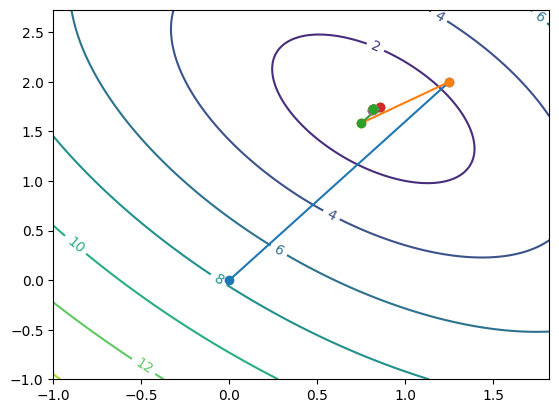

In [25]:
max_iter = 100  # ALWAYS HAVE A FAILSAFE WHEN YOU PLAY WITH INFINITE LOOPS!
tolerance = 1e-6
A = np.array([[4, 1], [1, 3]])
b = np.array([5, 6])
x0 = np.array([0., 0.])

x_true = np.linalg.solve(A, b)
print('The true answer is ', x_true)


# Utility function to autoscale the plot limits to include x0 and x_true
def calculate_box_limits(point1, point2, padding=1.0):
    # Extract coordinates
    x1, y1 = point1
    x2, y2 = point2
    # Calculate min and max coordinates with padding
    min_x = min(x1, x2) - padding
    max_x = max(x1, x2) + padding
    min_y = min(y1, y2) - padding
    max_y = max(y1, y2) + padding
    return (min_x, max_x, min_y, max_y)


xb, xe, yb, ye = calculate_box_limits(x0, x_true)
# Plot the linear system
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
x = np.linspace(xb, xe, 100)
y = np.linspace(yb, ye, 100)
X, Y = np.meshgrid(x, y)
V = np.stack((X,Y),-1)
Z = np.linalg.norm(np.matmul(V,A.T)-b, axis = -1)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)


method = jacobi_step
#method = gauss_seidel_step
#method = sor_step


for i in range(max_iter):
  x_new = method(A, b, x0.copy())
  R = np.linalg.norm(A@x_new-b)

  print('Iteration ', i, ' determined ', x_new, 'with residual', R)
  plt.plot([x0[0], x_new[0]], [x0[1], x_new[1]], '-o')
  if np.linalg.norm(R) < tolerance:
    print('Converged after, ', i, ' iterations to: ', x_new)
    break
  x0 = x_new.copy()


## Example: Iteratively solve a large matrix

In [26]:
# prompt: Form a large, sparse linear system with a diagonally dominant random matrix

import numpy as np

def create_diagonally_dominant_matrix(n):
  """Creates a diagonally dominant random matrix.

  Args:
    n: The size of the matrix.

  Returns:
    A diagonally dominant random matrix.
  """

  A = np.random.rand(n, n)
  for i in range(n):
    A[i, i] = np.sum(np.abs(A[i, :])) + np.random.rand()  # Ensure diagonal dominance

  return A


In [27]:
# put this into a function for convenience
def iter_solve(A, b, method):
  x0 = np.zeros(b.shape[0])

  max_iter = 1000
  tolerance = 1e-6

  for i in range(max_iter):
    x_new = method(A, b, x0.copy())
    R = np.linalg.norm(A@x_new-b)

    #print('Iteration ', i, ' determined ', x_new, 'with residual', R)
    if np.linalg.norm(R) < tolerance:
      print('Converged after, ', i, ' iterations.')
      break
    x0 = x_new.copy()

### n=4

In [28]:
n = 4  # Size of the matrix
A = create_diagonally_dominant_matrix(n)
b = np.random.rand(n)  # Create a random right-hand side vector

print('LU')
%timeit -n1 -r1 np.linalg.solve(A, b)

print('\nJacobi')
%timeit -n1 -r1 iter_solve(A, b, jacobi_step)
print('\nGauss-Seidel')
%timeit -n1 -r1 iter_solve(A, b, gauss_seidel_step)
print('\nSOR')
%timeit -n1 -r1 iter_solve(A, b, sor_step)

LU
90.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Jacobi
Converged after,  18  iterations.
6.07 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Gauss-Seidel
Converged after,  6  iterations.
1.61 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SOR
Converged after,  6  iterations.
3.14 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### n = 100

In [17]:
n = 100  # Size of the matrix
A = create_diagonally_dominant_matrix(n)
b = np.random.rand(n)  # Create a random right-hand side vector

print('LU')
%timeit -n1 -r1 np.linalg.solve(A, b)

print('\nJacobi')
%timeit -n1 -r1 iter_solve(A, b, jacobi_step)
print('\nGauss-Seidel')
%timeit -n1 -r1 iter_solve(A, b, gauss_seidel_step)
print('\nSOR')
%timeit -n1 -r1 iter_solve(A, b, sor_step)

LU
5.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Jacobi
Converged after,  787  iterations.
1.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Gauss-Seidel
Converged after,  10  iterations.
19.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SOR
Converged after,  11  iterations.
12.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### n = 1000

In [29]:
n = 1000  # Size of the matrix
A = create_diagonally_dominant_matrix(n)
b = np.random.rand(n)  # Create a random right-hand side vector

print('LU')
%timeit -n1 -r1 np.linalg.solve(A, b)

#print('\nJacobi')
#%timeit -n1 -r1 iter_solve(A, b, jacobi_step)
print('\nGauss-Seidel')
%timeit -n1 -r1 iter_solve(A, b, gauss_seidel_step)
#print('\nSOR')
#%timeit -n1 -r1 iter_solve(A, b, sor_step)

LU
50.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Gauss-Seidel
Converged after,  10  iterations.
115 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### n = 3000

In [30]:
n = 3000  # Size of the matrix
A = create_diagonally_dominant_matrix(n)
b = np.random.rand(n)  # Create a random right-hand side vector

print('LU')
%timeit -n1 -r1 np.linalg.solve(A, b)

#print('\nJacobi')
#%timeit -n1 -r1 iter_solve(A, b, jacobi_step)
print('\nGauss-Seidel')
%timeit -n1 -r1 iter_solve(A, b, gauss_seidel_step)
#print('\nSOR')
#%timeit -n1 -r1 iter_solve(A, b, sor_step)

LU
692 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Gauss-Seidel
Converged after,  10  iterations.
411 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### n = 5000

HERE WE GO!
Remember, this is a terrible implementation of GS! Numpy with loops is going to be slow!

In [31]:
n = 5000  # Size of the matrix
A = create_diagonally_dominant_matrix(n)
b = np.random.rand(n)  # Create a random right-hand side vector

print('LU')
%timeit -n1 -r1 np.linalg.solve(A, b)

#print('\nJacobi')
#%timeit -n1 -r1 iter_solve(A, b, jacobi_step)
print('\nGauss-Seidel')
%timeit -n1 -r1 iter_solve(A, b, gauss_seidel_step)
#print('\nSOR')
#%timeit -n1 -r1 iter_solve(A, b, sor_step)

LU
2.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Gauss-Seidel
Converged after,  11  iterations.
874 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
